In [3]:
import tensorflow as tf
import tensorflow.examples.tutorials.mnist.input_data as input_data

In [4]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
def weight(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1),name='W')

In [6]:
def bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape),name='b')

In [7]:
def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')

In [8]:
def max_pool_2x2(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

In [9]:
with tf.name_scope('Input_Layer'):
    x = tf.placeholder("float",shape=[None,784],name="x")
    x_image = tf.reshape(x,[-1,28,28,1])

In [10]:
with tf.name_scope('C1_Conv'):
    W1 = weight([5,5,1,16])
    b1 = bias([16])
    Conv1=conv2d(x_image,W1)+b1
    C1_Conv = tf.nn.relu(Conv1)

In [11]:
with tf.name_scope('C1_Pool'):
    C1_Pool = max_pool_2x2(C1_Conv)

In [12]:
with tf.name_scope('C2_Conv'):
    W2 = weight([5,5,16,36])
    b2 = bias([36])
    Conv2=conv2d(C1_Pool,W2)+b2
    C2_Conv = tf.nn.relu(Conv2)

In [13]:
with tf.name_scope('C2_Pool'):
    C2_Pool = max_pool_2x2(C2_Conv)

In [14]:
with tf.name_scope('D_Flat'):
    D_Flat = tf.reshape(C2_Pool,[-1,1764])

In [15]:
with tf.name_scope('D_Hidden_Layer'):
    W3 = weight([1764,128])
    b3 = bias([128])
    D_Hidden = tf.nn.relu(tf.matmul(D_Flat,W3)+b3)
    D_Hidden_Dropout=tf.nn.dropout(D_Hidden,keep_prob=0.8)

In [16]:
with tf.name_scope('Output_Layer'):
    W4 = weight([128,10])
    b4 = bias([10])
    y_predict = tf.nn.softmax(tf.matmul(D_Hidden_Dropout,W4)+b4)

In [17]:
with tf.name_scope("optimizer"):
    y_label = tf.placeholder("float", [None,10],name="y_Label")
    loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_predict,labels=y_label))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)\
                        .minimize(loss_function)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [18]:
with tf.name_scope("evaluate_model"):
    correct_prediction = tf.equal(tf.argmax(y_label,1),tf.argmax(y_predict,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))

In [19]:
trainEpochs = 5
batchSize = 100
totalBatchs=int(mnist.train.num_examples/batchSize)
loss_list=[];epoch_list=[];accuracy_list=[]
from time import time
startTime=time()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [20]:
for epoch in range(trainEpochs):
    for i in range(totalBatchs):
        batch_x,batch_y = mnist.train.next_batch(batchSize)
        sess.run(optimizer,feed_dict={x:batch_x,y_label:batch_y})
    loss,acc = sess.run([loss_function,accuracy],feed_dict={x:mnist.validation.images,y_label:mnist.validation.labels})
    epoch_list.append(epoch);
    loss_list.append(loss)
    accuracy_list.append(acc)
    print("Train Epoch:",'%02d' %(epoch+1),"Loss=",\
         "{:.9f}".format(loss),"Accuracy=",acc)
duration = time()-startTime
print("Train Finished takes:",duration)

Train Epoch: 01 Loss= 1.496210933 Accuracy= 0.967
Train Epoch: 02 Loss= 1.485611916 Accuracy= 0.9762
Train Epoch: 03 Loss= 1.481222510 Accuracy= 0.9794
Train Epoch: 04 Loss= 1.476513863 Accuracy= 0.9848
Train Epoch: 05 Loss= 1.476587534 Accuracy= 0.9852
Train Finished takes: 456.6948742866516


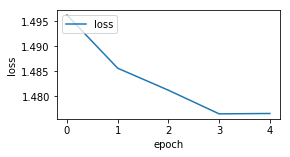

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.gcf()
fig.set_size_inches(4,2)
plt.plot(epoch_list,loss_list,label = 'loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'],loc='upper left')

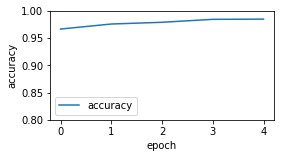

In [22]:
plt.plot(epoch_list,accuracy_list,label="accuracy")
fig = plt.gcf()
fig.set_size_inches(4,2)
plt.ylim(0.8,1)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [23]:
print("Accuracy:",sess.run(accuracy,feed_dict={x:mnist.test.images,y_label:mnist.test.labels}))

Accuracy: 0.9853


In [24]:
prediction_result=sess.run(tf.argmax(y_predict,1),feed_dict={x:mnist.test.images})

In [25]:
prediction_result[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=int64)

In [26]:
import matplotlib.pyplot as plt
import numpy as np
def plot_images_labels_prediction(images,labels,prediction,idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if num>25: num=25
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        
        ax.imshow(np.reshape(images[idx],(28,28)), cmap='binary')
        
        title="label=" +str(np.argmax(labels[idx]))
        if len(prediction)>0:
            title+=",predict=" +str(prediction[idx])
            
        ax.set_title(title,fontsize=10)
        ax.set_xticks([]);ax.set_yticks([])
        idx+=1
    plt.show()

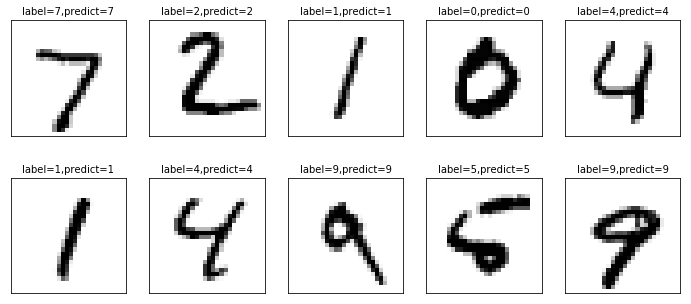

In [27]:
plot_images_labels_prediction(mnist.test.images,mnist.test.labels,prediction_result,0)

In [28]:
merged = tf.summary.merge_all()
train_write = tf.summary.FileWriter('log/CNN',sess.graph)